In [3]:
#This notebook will run an example on howto use xthreat from socceraction module.
#The source code for xthreat is here:
#https://github.com/ML-KULeuven/socceraction/blob/master/socceraction/xthreat.py

# A very good resource for our efforts to repliocate the model using hockey data

#again, just stealing code from: https://github.com/ML-KULeuven/socceraction/blob/master/public-notebooks/EXTRA-run-xT.ipynb

# easy to install socceraction module using pip install socceraction --user
# make sure to upgrade pandas to the latest version or else code won't work
# pip install --upgrade pandas

#libraries
import os
import tqdm
import pandas as pd
import numpy as np
import socceraction.vaep.features as fs
import socceraction.xthreat as xthreat

In [5]:
## Configure file and folder names, use SPADL format.
datafolder = "data-fifa"
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")
xT_h5 = os.path.join(datafolder, "xT.h5")

## Select games
games = pd.read_hdf(spadl_h5, "games")
games = games[games.competition_id == 43]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")

## Read in all actions of games
A = []

for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes, how="left")
        .merge(results, how="left")
        .merge(bodyparts, how="left")
        #.sort_values(["period_id", "time_seconds"])
        .reset_index(drop=True)
    )
    [actions] = fs.play_left_to_right([actions], game.home_team_id)
        
    A.append(actions) 
    
A = pd.concat(A)
A.reset_index(inplace=True,drop=True)

#something messy I did to use later ignore---------
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
h = games[['home_team_id','home_team_name']].rename(
columns={
    'home_team_id':'team_id',
    'home_team_name':'team_name'
}
).set_index('team_id')
a = games[['away_team_id','away_team_name']].rename(
columns={
    'away_team_id':'team_id',
    'away_team_name':'team_name'
}
).set_index('team_id')

team_name_dict = pd.concat([h,a]).to_dict()['team_name']

  6%|█████▏                                                                             | 4/64 [00:00<00:01, 36.84it/s]

nb of games: 64


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 34.75it/s]


In [6]:
#alright so this is how the data is supposed to look like.
# Seems like we need to prepare the data by adding the result of the play in terms of location
# which is basically just lookng at coordinates of the next event (except when it fails)
# so it will require some programming to figure out the correct end_x and end_y
# we have binary variables for fail/success which we can also calculate
A.head(5)

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name
0,7581,ec5ba260-9bd3-4c5a-b7a5-9f9168ea905d,1,1.0,776,3043,52.941176,33.569620,31.764706,37.012658,0,1,0,0,pass,success,foot
1,7581,abb799d1-73d8-4119-b23f-40f79765f8f8,1,2.0,776,3027,31.764706,37.012658,32.647059,32.708861,21,1,0,1,dribble,success,foot
2,7581,9d3fc438-e85d-49fa-8ff4-21cb3bcc54b1,1,4.0,776,3027,32.647059,32.708861,84.705882,19.797468,0,0,0,2,pass,fail,foot
3,7581,5be94fcb-9612-4f00-82b6-3728f4f1b45c,1,7.0,785,5468,20.294118,48.202532,41.470588,40.455696,0,0,1,3,pass,fail,head
4,7581,0370171b-81a7-49e6-809c-3ade48258b5e,1,9.0,776,5527,63.529412,27.544304,59.117647,27.544304,0,1,1,4,pass,success,head


In [7]:
# This is when they run the xT function. again we can find it here:
# https://github.com/ML-KULeuven/socceraction/blob/master/socceraction/xthreat.py
## Train model
xTModel = xthreat.ExpectedThreat(l=16, w=12) # seems like we can specify the number of areas 
# which is cool
xTModel.fit(A);

#the model uses 45 iterations (and runs surprisingly fast)

# iterations:  45


In [8]:
# Here's where the guy predicts xT and makes a cool table. Very interpretable

## Predict

# xT should only be used to value actions that move the ball 
# and also keep the current team in possession of the ball
mov_actions = xthreat.get_successful_move_actions(A)
mov_actions["xT_value"] = xTModel.predict(mov_actions)

print(
'"xT should only be used to value actions that move the ball \nand also keep the current team in possession of the ball"'
)
print('\nThis statement is exactly my reservation with xT: \nit can only quantify for succesful plays')

print("\nHowever, we can present it as an extension of XGoals. Should be easy to sell")

mov_actions[
    ["result_name","team_id","type_name", "start_x", "start_y", "end_x", "end_y", "xT_value"]
][:10]


"xT should only be used to value actions that move the ball 
and also keep the current team in possession of the ball"

This statement is exactly my reservation with xT: 
it can only quantify for succesful plays

However, we can present it as an extension of XGoals. Should be easy to sell


,result_name,team_id,type_name,start_x,start_y,end_x,end_y,xT_value
0,success,776,pass,52.941176,33.569620,31.764706,37.012658,-0.003840
1,success,776,dribble,31.764706,37.012658,32.647059,32.708861,-0.000070
4,success,776,pass,63.529412,27.544304,59.117647,27.544304,0.000000
5,success,776,dribble,59.117647,27.544304,65.294118,25.822785,0.000000
8,success,776,pass,59.117647,25.822785,67.058824,24.962025,0.001580
9,success,776,dribble,67.058824,24.962025,67.058824,21.518987,-0.000517
12,success,776,pass,68.823529,14.632911,77.647059,27.544304,0.003146
13,success,776,dribble,77.647059,27.544304,76.764706,22.379747,-0.000317
17,success,776,dribble,98.823529,34.430380,99.705882,36.151899,0.000000
18,success,776,pass,99.705882,36.151899,99.705882,40.455696,-0.102173


In [9]:
comp=mov_actions[
    ["xT_value"]
]
comp=A.join(comp,how='left')

#This helps us to understand oh xT works.
comp[
    ["result_name","team_id","type_name", "start_x", "start_y", "end_x", "end_y", "xT_value"]
][:10]

,result_name,team_id,type_name,start_x,start_y,end_x,end_y,xT_value
0,success,776,pass,52.941176,33.569620,31.764706,37.012658,-0.003840
1,success,776,dribble,31.764706,37.012658,32.647059,32.708861,-0.000070
2,fail,776,pass,32.647059,32.708861,84.705882,19.797468,NaN
3,fail,785,pass,20.294118,48.202532,41.470588,40.455696,NaN
4,success,776,pass,63.529412,27.544304,59.117647,27.544304,0.000000
5,success,776,dribble,59.117647,27.544304,65.294118,25.822785,0.000000
6,fail,776,pass,65.294118,25.822785,71.470588,23.240506,NaN
7,fail,785,pass,33.529412,44.759494,45.882353,42.177215,NaN
8,success,776,pass,59.117647,25.822785,67.058824,24.962025,0.001580
9,success,776,dribble,67.058824,24.962025,67.058824,21.518987,-0.000517


In [10]:
#Team 785 didn't get two consecutive 
#successful plays until row indexed as 29 (seems like throw_in doesn't count)

#In this subset, team 785 finally had a series of good successful plays
mov_actions[
    ["result_name","team_id","type_name", "start_x", "start_y", "end_x", "end_y", "xT_value"]
][30:40]

,result_name,team_id,type_name,start_x,start_y,end_x,end_y,xT_value
49,success,785,dribble,31.764706,6.025316,31.764706,6.025316,0.000000
50,success,785,pass,31.764706,6.025316,26.470588,32.708861,0.000921
51,success,785,dribble,26.470588,32.708861,27.352941,33.569620,0.000000
52,success,785,pass,27.352941,33.569620,33.529412,55.088608,0.000332
53,success,785,dribble,33.529412,55.088608,33.529412,55.088608,0.000000
54,success,785,pass,33.529412,55.088608,27.352941,42.177215,-0.000310
55,success,785,dribble,27.352941,42.177215,28.235294,42.177215,0.000000
56,success,785,pass,28.235294,42.177215,37.058824,51.645570,0.000310
57,success,785,dribble,37.058824,51.645570,28.235294,42.177215,-0.000310
58,success,785,pass,28.235294,42.177215,58.235294,1.721519,0.002077


In [11]:
#Top 10 teams
mov_actions['team']=mov_actions['team_id'].map(team_name_dict)
print("Top 10 offenses in terms of xT:")
pd.DataFrame(
    mov_actions.groupby('team')['xT_value'].sum()
            ).sort_values(
    by='xT_value',ascending=False
                         ).head(10)

Top 10 offenses in terms of xT:


,xT_value
team,
Belgium,7.591213
Brazil,7.559588
Croatia,5.792014
Spain,5.619898
Germany,5.595109
England,5.471427
France,4.860911
Serbia,4.028740
Uruguay,3.657687


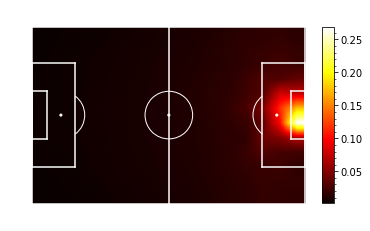

In [15]:
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

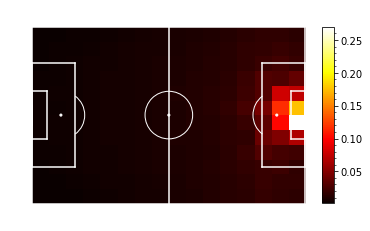

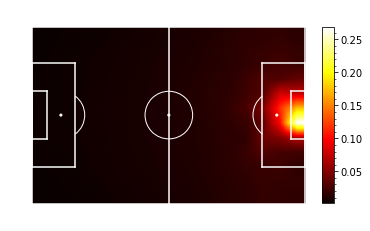

In [12]:
import matplotsoccer as mps

# Inspect the learned heatmap
mps.heatmap(xTModel.xT, cmap="hot", linecolor="white", cbar="True")

# Inspect the interpolated heatmap used for predictions
interp = xTModel.interpolator()
x = np.linspace(0, 105, 1050)
y = np.linspace(0, 68, 680)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

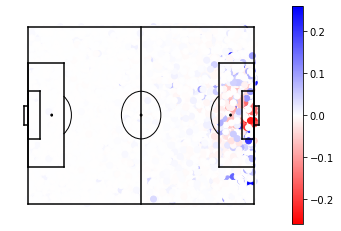

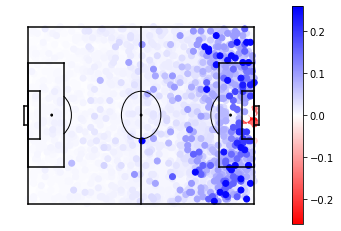

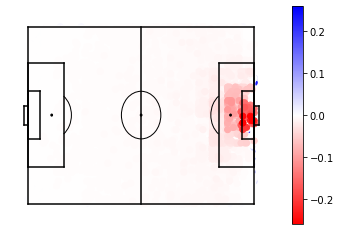

In [17]:
import matplotlib.pyplot as plt

## Visualize xT predictions 
a = mov_actions

# Show scatterplot of actions colored according to xT value
mps.field(show=False)
plt.scatter(a.start_x, a.start_y,c=a.xT_value,cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with high xT Values on top
a = a.sort_values("xT_value",ascending=True)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y,c=a.xT_value,cmap="bwr_r")
plt.colorbar()
plt.show()

# Show actions with low xT Values on top
a = a.sort_values("xT_value",ascending=False)
mps.field(show=False)
plt.scatter(a.start_x, a.start_y,c=a.xT_value,cmap="bwr_r")
plt.colorbar()
plt.show()

In [19]:
import plotly.graph_objects as go

def visualize_surface_plots(xTModel):
    """ Visualizes the surface plot of each iteration of the model.

        See https://plot.ly/python/sliders/ and https://karun.in/blog/expected-threat.html#visualizing-xt
        NOTE: y-axis is mirrored in plotly.
    """
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-2.25, y=-1, z=0.5),
    )

    max_z = np.around(xTModel.xT.max() + 0.05, decimals=1)

    layout = go.Layout(
        title="Expected Threat",
        autosize=True,
        width=500,
        height=500,
        margin=dict(l=65, r=50, b=65, t=90),
        scene=dict(
            camera=camera,
            aspectmode="auto",
            xaxis=dict(),
            yaxis=dict(),
            zaxis=dict(autorange=False, range=[0, max_z]),
        ),
    )

    fig = go.Figure(layout=layout)

    for i in xTModel.heatmaps:
        fig.add_trace(go.Surface(z=i))

    # Make last trace visible
    for i in range(len(fig.data) - 1):
        fig.data[i].visible = False
    fig.data[len(fig.data) - 1].visible = True

    # Create and add slider
    steps = []
    for i in range(len(fig.data)):
        step = dict(method="restyle", args=["visible", [False] * len(fig.data)])
        step["args"][1][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [
        dict(
            active=(len(fig.data) - 1),
            currentvalue={"prefix": "Iteration: "},
            pad={"t": 50},
            steps=steps,
        )
    ]

    fig.update_layout(sliders=sliders)
    fig.show()
    
visualize_surface_plots(xTModel)

ModuleNotFoundError: No module named 'plotly'